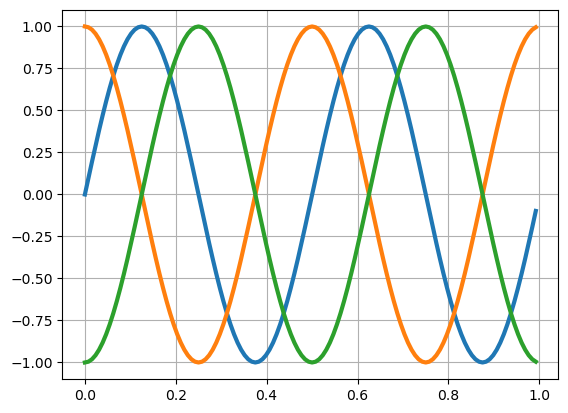

In [2]:
import numpy as np
from matplotlib import pyplot as plt 


N = 128 
f = 2 
a = 1 
t = np.arange(N)/N

phase = 0 * (2*np.pi/360)
signal = a * np.sin( 2*np.pi*t*f + phase)
plt.plot(t, signal, lw=3)

phase = 90 * (2*np.pi/360)
signal = a * np.sin( 2*np.pi*t*f + phase)
plt.plot(t, signal, lw=3)

phase = -90 * (2*np.pi/360)
signal = a * np.sin( 2*np.pi*t*f + phase)
plt.plot(t, signal, lw=3)

plt.grid()

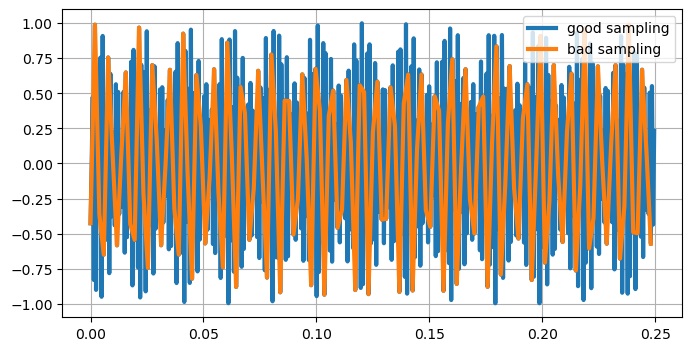

In [3]:
# s_n = sum_m a_m sin( 2 pi f_m t + phase )

def create_signal(amp, freq, phase, t): 
    signal = 0
    for n in range(len(amp)):
        signal += amp[n] * np.sin( 2*np.pi*t*freq[n] + phase[n]*(2*np.pi/360))

    return signal 

sample_rate = 512 
N = 128
t = np.arange(N)/sample_rate

M = 2
a = np.random.rand(M)
a = a/a.sum()
f = 20 + np.random.rand(M)*980
phase = (np.random.rand(M)-1/2)*360

sig = create_signal(a,f,phase,t)
c = 4
t2 = np.arange(N*c)/(sample_rate*c)
sig2 = create_signal(a,f,phase,t2)

plt.figure(figsize=(8,4))

plt.plot(t2,sig2,lw=3, label="good sampling")
plt.plot(t,sig,lw=3, label="bad sampling")
plt.legend()
plt.grid()





[0.10525125 0.03082676] [80, 84.22754194]


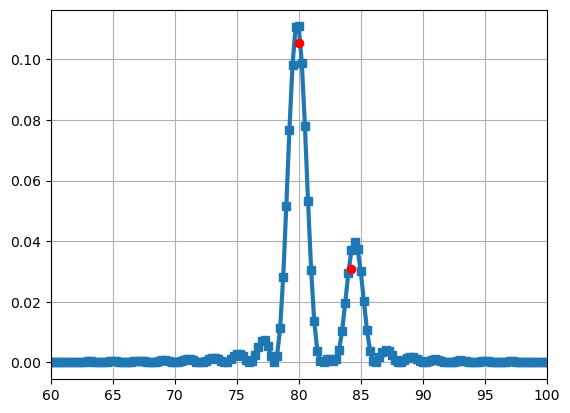

In [4]:
from numpy.fft import fft, fftshift, ifft 

sample_rate = 512 
N = 256
t = np.arange(N)/sample_rate

M = 2
a = np.random.rand(M)
a = a/a.sum()
f = [80,84.22754194] # 20 + np.random.rand(M)*128
phase = (np.random.rand(M)-1/2)*360 *0

sig = create_signal(a,f,phase,t)

Nfft = 8*N
TF = fft(sig, Nfft) / N

Spectre = np.abs(TF)**2

frequences = (np.arange(len(Spectre))/len(Spectre)) * (sample_rate)

print((a/2)**2,f)

plt.plot(frequences, (Spectre),'s-', lw=3)
plt.plot(f,(a/2)**2,'or')
plt.xlim((60,100))
plt.grid()

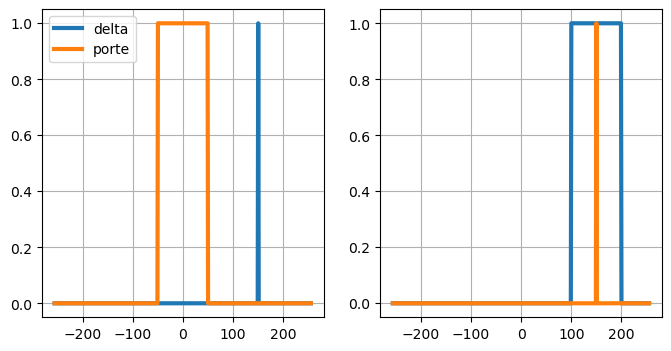

In [5]:
N = 512 

delta = np.zeros(N)
delta[150+N//2]=1

porte = np.zeros(N)
porte[N//2-50:N//2+50] = 1 

t = np.arange(N)-N/2

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(t,delta,lw=3, label="delta")
plt.plot(t,porte,lw=3, label="porte")
plt.grid()
plt.legend()

convolution = fftshift(np.real( ifft( fft(delta) * fft(porte))  ))

plt.subplot(122)
plt.plot(t,convolution,lw=3, label="porte conv porte")
plt.plot(t,delta,lw=3, label="delta")
plt.grid()

In [6]:
import librosa
import sounddevice as sd
from os.path import join 
from os import listdir

path_reverb = "Imreverbs"



filename = 'cat_10.wav'

y, Fs = librosa.load(filename)
y = y[Fs:int(5.45*Fs)]

sd.play(y, Fs)

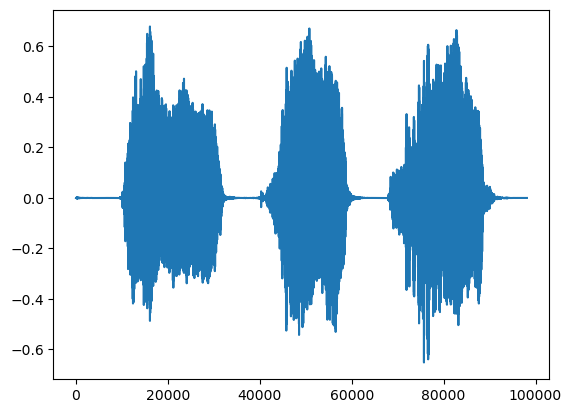

In [7]:
plt.plot(y)

Text(0.5, 1.0, '0.45351473922902497')

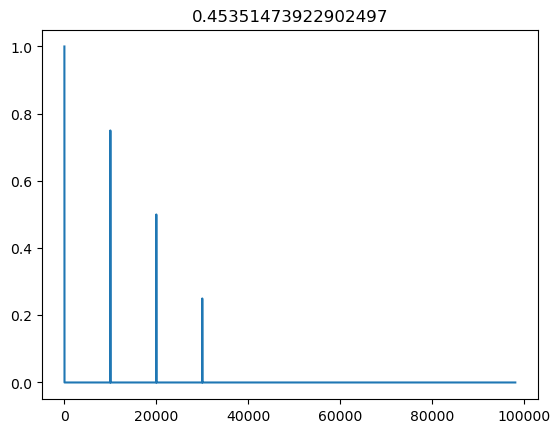

In [8]:
N = len(y)
echo = np.zeros(N)
echo[0] = 1 
delay = 10000
echo[delay] = .75
echo[delay*2] = .5
echo[delay*3] = .25


plt.plot(echo)
plt.title(delay/Fs)

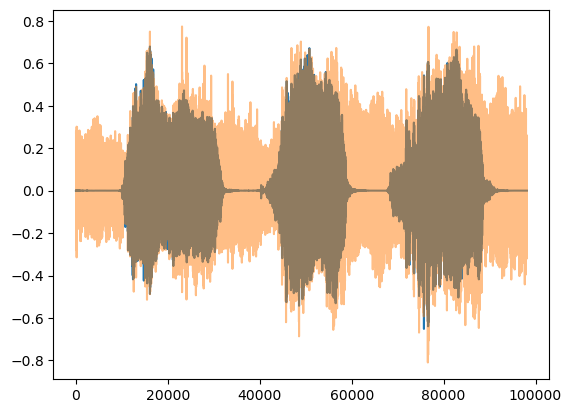

In [9]:

convolution = np.real( ifft( fft(y) * fft(echo) ) ) 

plt.plot(y)
plt.plot(convolution, alpha=.5)


In [10]:
sd.play(convolution, Fs)


(0.0, 11025.0)

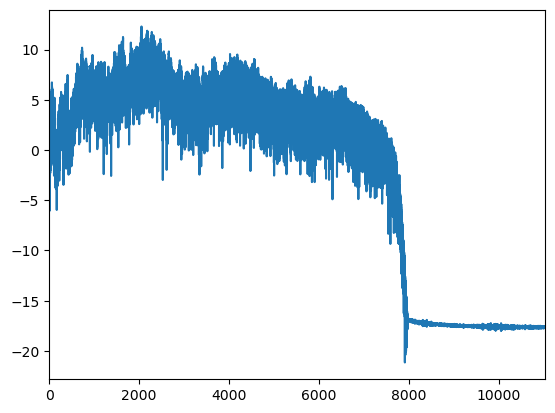

In [11]:
TF = np.log(np.abs(fft(y))**2)
f = np.arange(len(TF)) *Fs/len(TF)
plt.plot(f, TF)
plt.xlim((0,Fs//2))

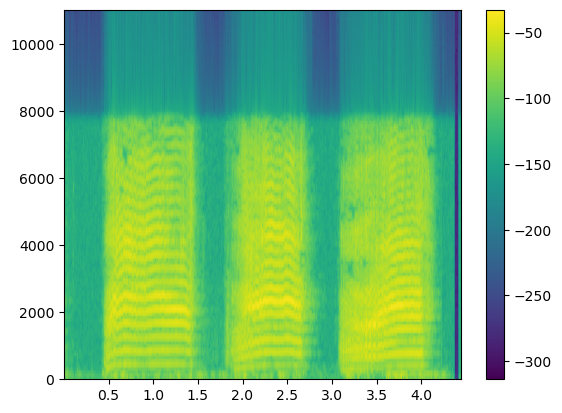

In [12]:

plt.specgram(y, Fs=Fs)
plt.colorbar()

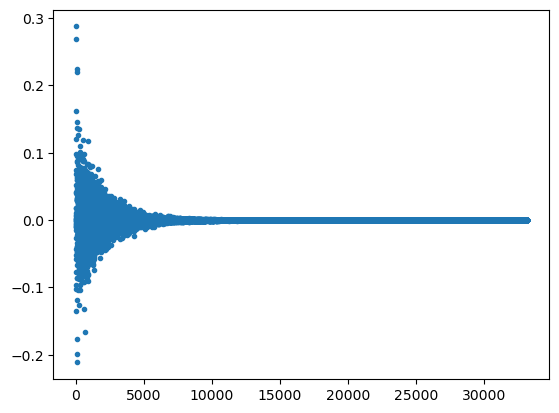

In [13]:
files = listdir(path_reverb)
reverb,_ = librosa.load(join(path_reverb,files[18]))

plt.plot(reverb,'.')

Nfft = np.maximum(len(y),len(reverb))

convolution = np.real( ifft( fft(y,Nfft) * fft(reverb,Nfft) ) ) 
sd.play(convolution, Fs)

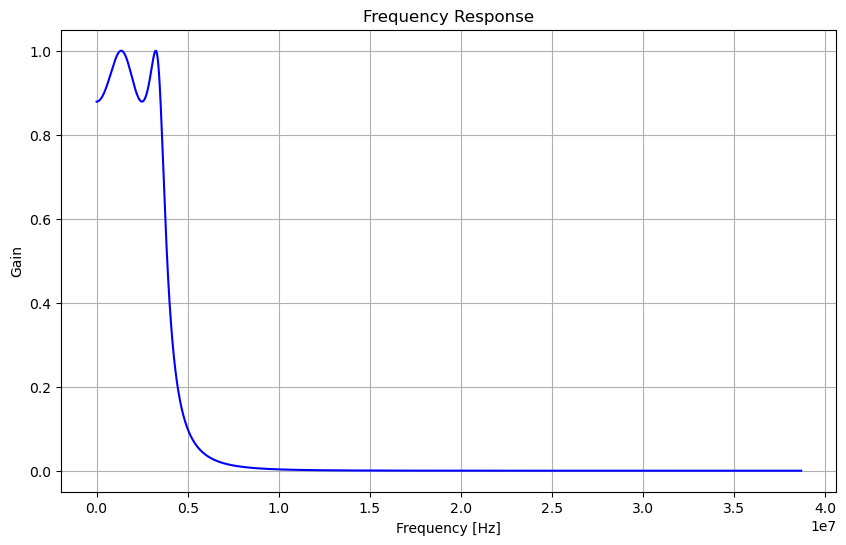

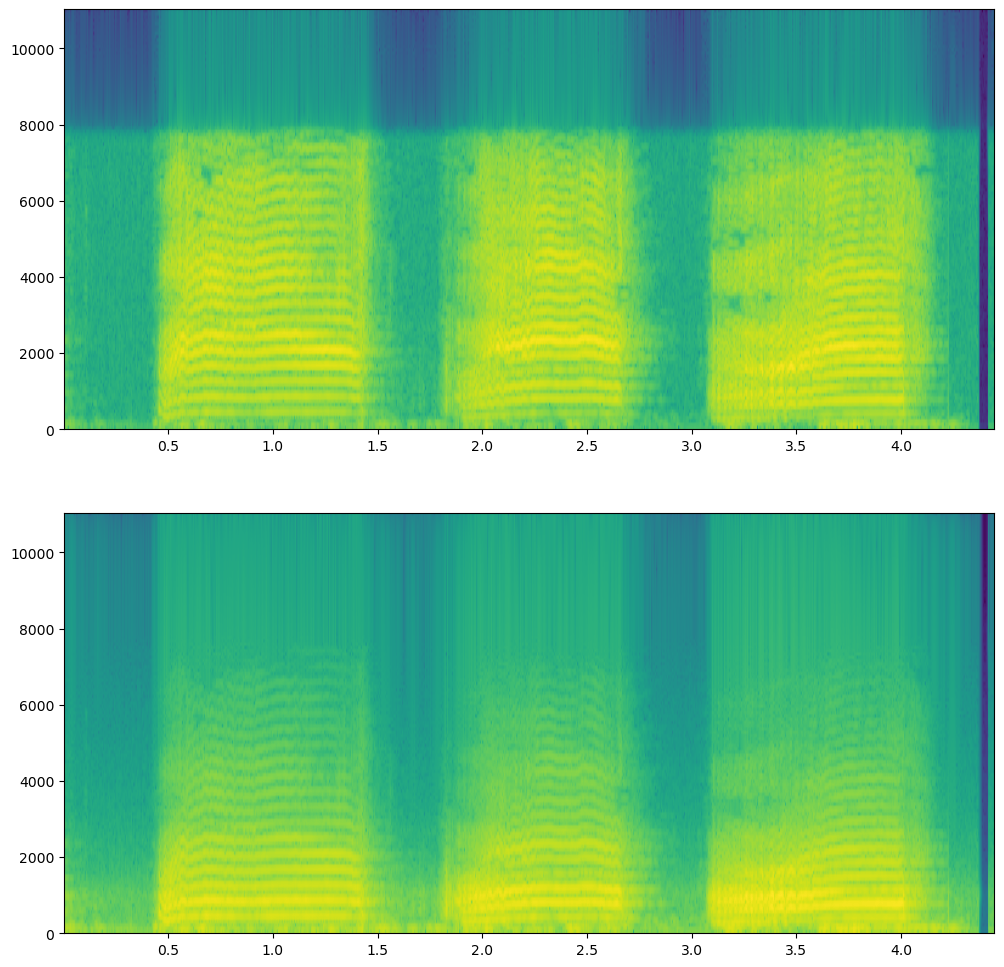

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cheby1, lfilter, freqz
from scipy.io.wavfile import read, write


def plot_frequency_response(b, a, fs):
    w, h = freqz(b, a, worN=8000, fs=fs)

    plt.figure(figsize=(10, 6))
    plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
    plt.title('Frequency Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()
    plt.show()


# Fonction pour appliquer un filtre à un signal audio
def apply_filter(y, fs, cutoff_freq, ripple_db):

    # Conception du filtre de Tchebychev
    nyquist_freq = 0.5 * fs
    rp = 10**(ripple_db / 20.0)  # Convertir le ripple en amplitude
    n, Wn = cheby1(N=4, rp=rp, Wn=cutoff_freq/nyquist_freq, btype='low', analog=False, output='ba')

    # Appliquer le filtre au signal audio
    filtered_audio = lfilter(n, Wn, y)

    return filtered_audio, n, Wn

# Paramètres du filtre de Tchebychev
cutoff_frequency = 1000.0  # Fréquence de coupure en Hz
ripple_db = 1.0  # Amplitude des ripples en décibels


# Appliquer le filtre de Tchebychev au signal audio
output_audio_file, n, Wn = apply_filter(y,Fs, cutoff_frequency, ripple_db)

plot_frequency_response(n, Wn, Fs)

plt.figure(figsize=(12,12))
plt.subplot(211)
plt.specgram(y,Fs=Fs)

plt.subplot(212)
plt.specgram(output_audio_file,Fs=Fs)

output_audio_file/=output_audio_file.max()
sd.play(output_audio_file,Fs)


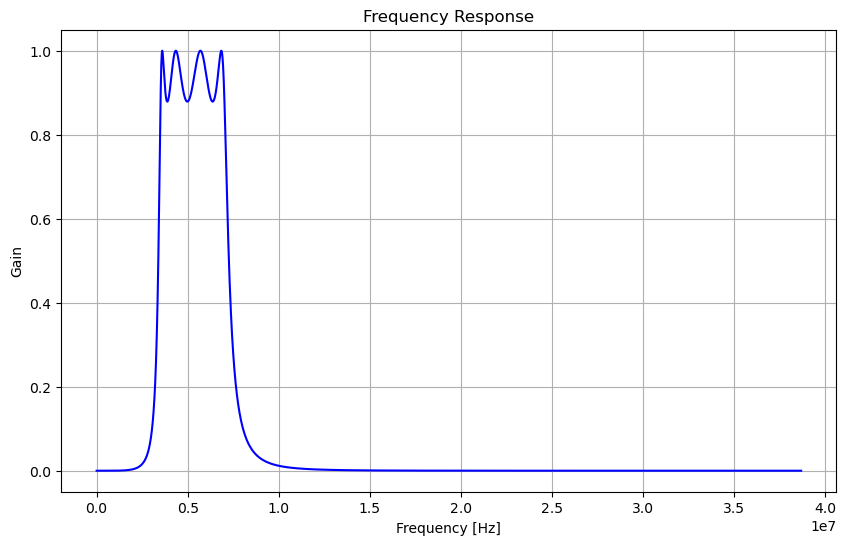

(array([[1.52065142e-21, 1.32659854e-19, 2.25201314e-19, ...,
         3.14876328e-22, 6.35291641e-22, 8.03739129e-22],
        [6.73599985e-21, 2.84750705e-19, 4.04026470e-19, ...,
         7.46685774e-22, 1.51092267e-21, 1.64322925e-21],
        [5.40760500e-20, 2.34739890e-19, 7.40474975e-19, ...,
         1.15276100e-21, 3.20922448e-21, 9.12129243e-22],
        ...,
        [3.64312389e-25, 1.51259730e-24, 2.07960316e-24, ...,
         1.34973017e-26, 3.56346746e-27, 1.06285347e-27],
        [3.54985592e-25, 1.50094591e-24, 2.06715656e-24, ...,
         1.34300970e-26, 3.51698839e-27, 1.07787476e-27],
        [1.75941754e-25, 7.48535956e-25, 1.03150975e-24, ...,
         6.70387527e-27, 1.75078795e-27, 5.41454349e-28]]),
 array([    0.       ,    86.1328125,   172.265625 ,   258.3984375,
          344.53125  ,   430.6640625,   516.796875 ,   602.9296875,
          689.0625   ,   775.1953125,   861.328125 ,   947.4609375,
         1033.59375  ,  1119.7265625,  1205.859375 ,  1291.99

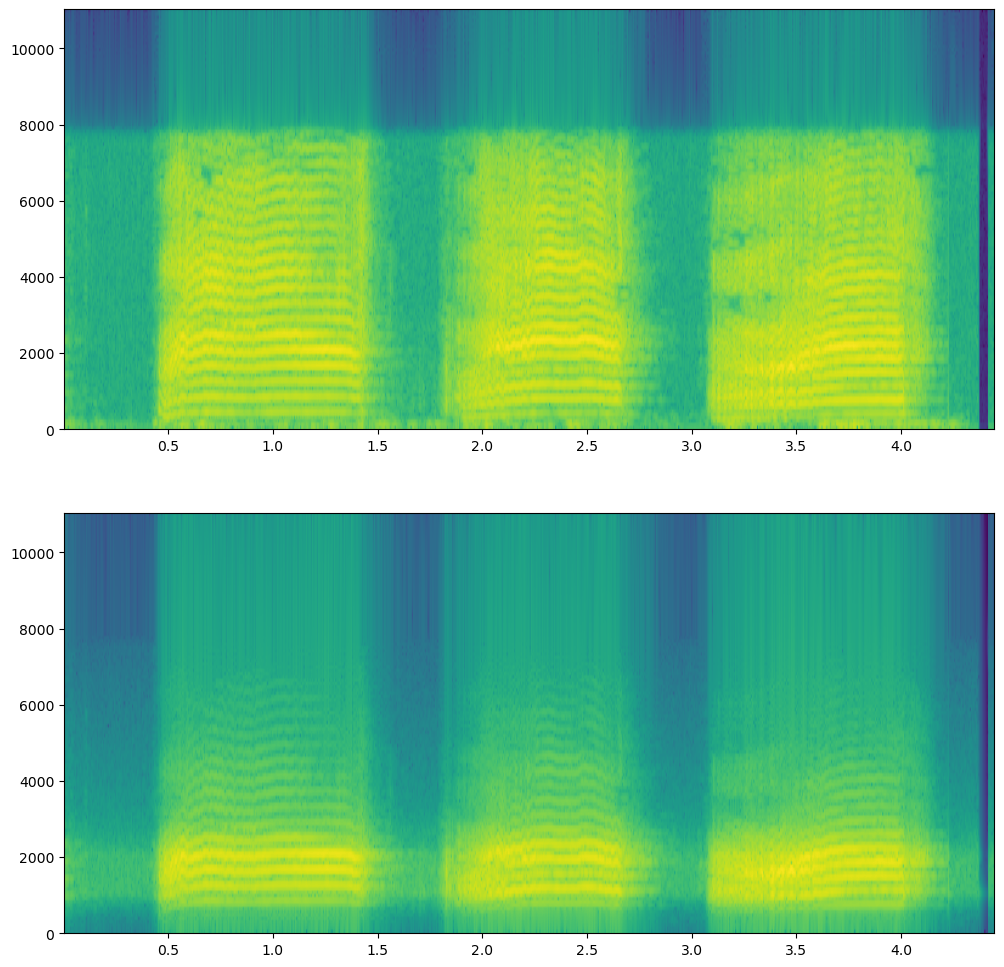

In [15]:

# exemple de passe bande 
def apply_bandpass_filter(y, fs, lowcut, highcut, ripple_db):
    nyquist_freq = 0.5 * fs
    rp = 10**(ripple_db / 20.0)  
    lowcut_normalized = lowcut / nyquist_freq
    highcut_normalized = highcut / nyquist_freq
    b, a = cheby1(N=4, rp=rp, Wn=[lowcut_normalized, highcut_normalized], btype='band', analog=False, output='ba')

    filtered_audio = lfilter(b, a, y)
    return filtered_audio, b,a

# Appliquer le filtre de Tchebychev au signal audio
output_audio_file, n, Wn = apply_bandpass_filter(y,Fs, 1000,2000, ripple_db)

plot_frequency_response(n, Wn, Fs)

plt.figure(figsize=(12,12))
plt.subplot(211)
plt.specgram(y,Fs=Fs)

plt.subplot(212)
plt.specgram(output_audio_file,Fs=Fs)

# output_audio_file/=output_audio_file.max()
# sd.play(output_audio_file,Fs)


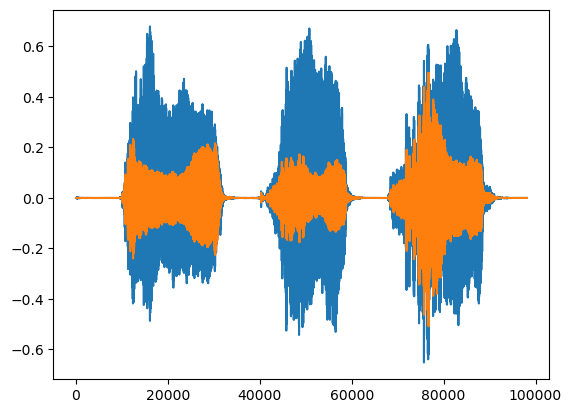

In [24]:
plt.plot(y)
plt.plot(output_audio_file)

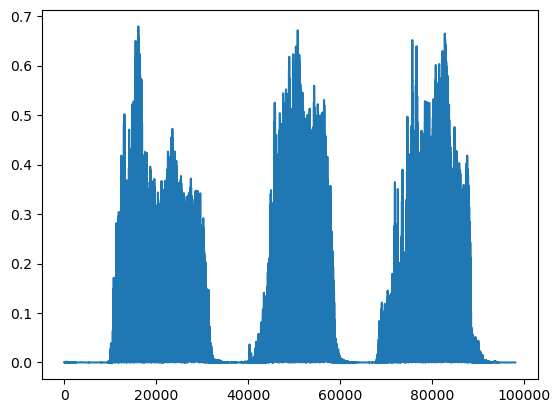

In [38]:
nrj = np.abs(y)
plt.plot(nrj,'-')
xx = nrj> .3*np.mean(nrj)
yy = nrj[xx]
# plt.plot(np.where(xx)[0],yy,'.')
# plt.xlim((20000,20100))

/var/folders/rm/t8nz30d94f36m8jh6lwtg3km0000gq/T/ipykernel_30061/1480609670.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  H = hann(T)


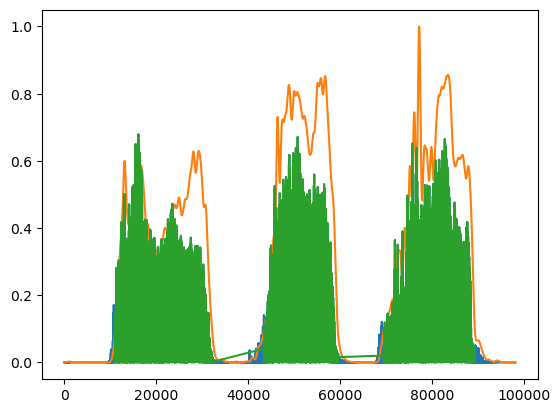

In [47]:
from scipy.signal import hann

def conv(a,b):
    Nfft = np.maximum(len(a),len(b))
    return np.real(ifft( fft(a,Nfft)*fft(b,Nfft)))

T = int( 50/1000 * Fs )
H = hann(T)
H = H/H.sum()
result = conv(nrj, H)
result = result/result.max()
plt.plot(nrj)
plt.plot(result)

seuil = .1
xx = result>seuil 
yy = nrj[xx]
plt.plot(np.where(xx)[0], yy)


(array([[1.90402783e-10, 3.25357018e-11, 9.25943191e-10, ...,
         5.10702571e-09, 2.20855476e-11, 3.28050056e-10],
        [1.80336197e-09, 1.97294986e-10, 3.83157614e-09, ...,
         1.44074008e-08, 3.28132680e-08, 2.84807880e-08],
        [1.20197922e-08, 1.50696941e-09, 1.68483250e-09, ...,
         2.30746236e-09, 9.66875312e-09, 1.64120444e-08],
        ...,
        [1.78982347e-19, 3.42071577e-19, 1.57298945e-18, ...,
         1.17700712e-18, 9.78929614e-19, 6.34305371e-19],
        [1.11068033e-19, 4.70544068e-19, 1.47204945e-18, ...,
         1.14465055e-18, 9.72648785e-19, 5.92994388e-19],
        [7.97392639e-20, 1.36901293e-19, 6.72041086e-19, ...,
         5.41391660e-19, 5.26415259e-19, 3.05822810e-19]]),
 array([    0.       ,    86.1328125,   172.265625 ,   258.3984375,
          344.53125  ,   430.6640625,   516.796875 ,   602.9296875,
          689.0625   ,   775.1953125,   861.328125 ,   947.4609375,
         1033.59375  ,  1119.7265625,  1205.859375 ,  1291.99

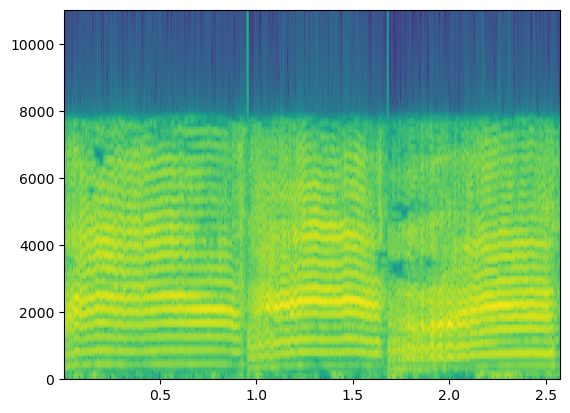

In [49]:
plt.specgram(y[xx],Fs=Fs)
